# 03.1 - hyperparameters influence on LGBM 

In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to sys.path:", project_root)

Project root added to sys.path: e:\.1\6 semestr\Podstawy sztucznej inteligencji\Projekt\football-prediction


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from pathlib import Path

from src.data_loader import load_data
from src.features import extract_features
from src.constants import FEATURE_COLUMNS
from src.model import _build_lgb

## Data Preparation
As before

In [4]:
input_path = Path.cwd().parent / "data" / "processed" / "model_input.parquet"

df = extract_features(load_data(input_path)).dropna(subset=FEATURE_COLUMNS + ["result"])
X, y = df[FEATURE_COLUMNS], df["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [5]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "accuracy": accuracy_score(y_test, y_pred)
    }

## Experiment Function

In [6]:
def run_lgb_experiment(param_name, param_values, base_config=None):
    if base_config is None:
        base_config = {}

    results = []

    for val in tqdm(param_values):
        cfg = base_config.copy()
        cfg[param_name] = val
        model = _build_lgb(cfg)
        model.fit(X_train_res, y_train_res)
        scores = evaluate(model, X_test, y_test)
        scores[param_name] = val
        results.append(scores)

    return pd.DataFrame(results)


In [7]:
def plot_results(df, param_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x=param_name, y="f1_macro", marker="o", ax=axes[0])
    axes[0].set_title(f"Macro F1 vs {param_name}")
    axes[0].grid(True)

    sns.lineplot(data=df, x=param_name, y="accuracy", marker="o", ax=axes[1])
    axes[1].set_title(f"Accuracy vs {param_name}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## Experiment: N-vals parameter

 14%|█▍        | 1/7 [00:00<00:01,  4.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 29%|██▊       | 2/7 [00:00<00:01,  2.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 43%|████▎     | 3/7 [00:01<00:01,  2.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 57%|█████▋    | 4/7 [00:01<00:01,  1.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 86%|████████▌ | 6/7 [00:02<00:00,  2.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


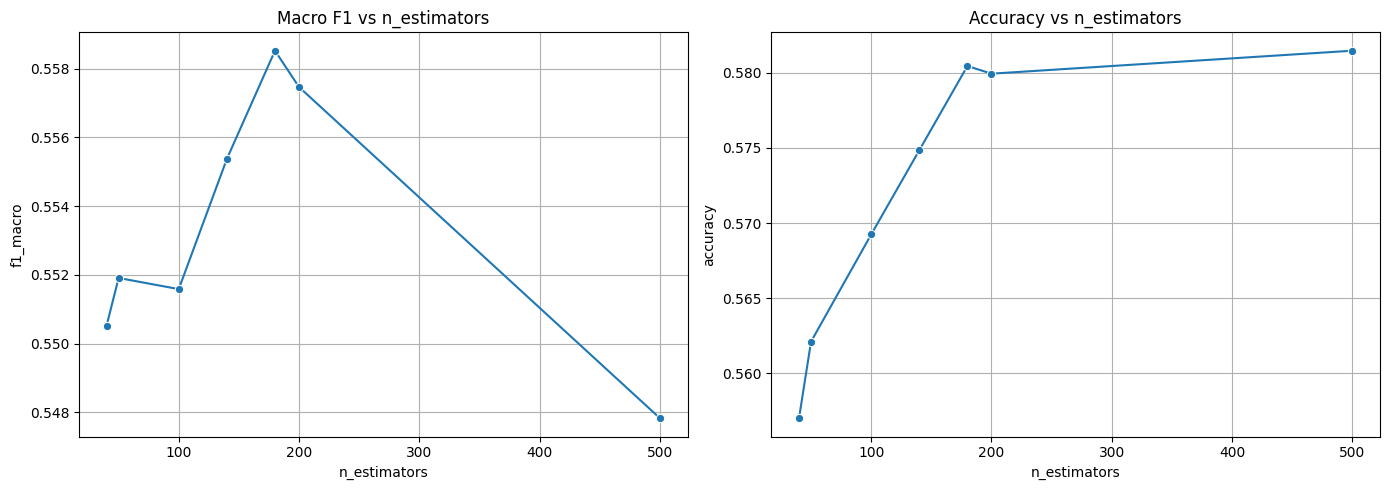

In [12]:
n_vals = [50, 100, 140, 180, 200, 40, 500]
df_n = run_lgb_experiment("n_estimators", n_vals)
plot_results(df_n, "n_estimators")

## Experiment: max_depth

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 20%|██        | 1/5 [00:00<00:02,  1.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 40%|████      | 2/5 [00:02<00:03,  1.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 60%|██████    | 3/5 [00:04<00:03,  1.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 80%|████████  | 4/5 [00:06<00:01,  1.90s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


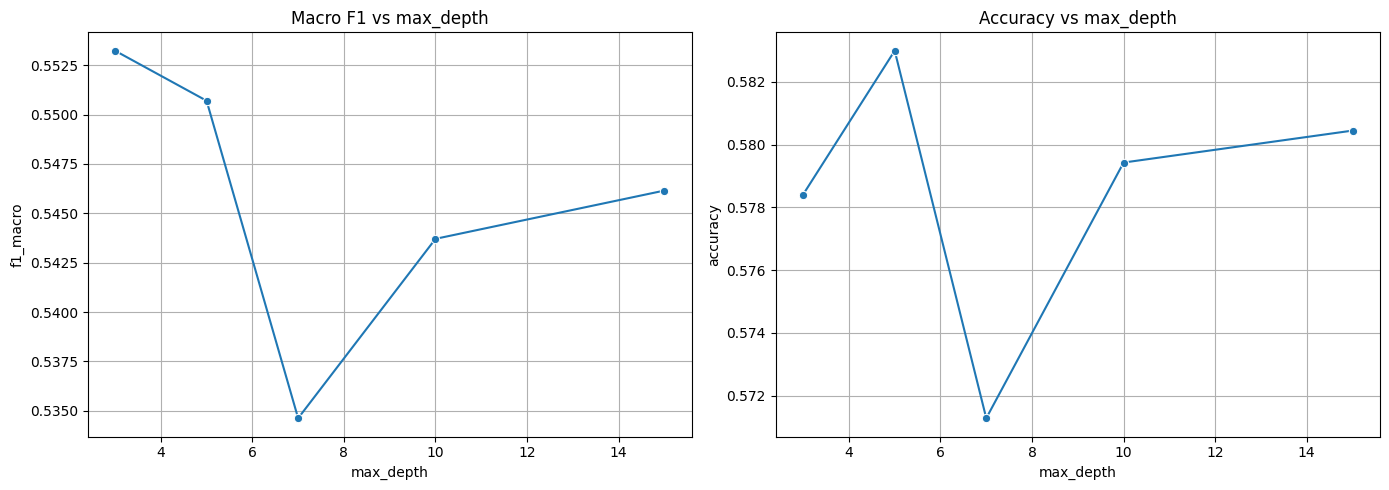

In [13]:
depth_vals = [3, 5, 7, 10, 15]
df_d = run_lgb_experiment("max_depth", depth_vals)
plot_results(df_d, "max_depth")

## Experiment: learning rate

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 17%|█▋        | 1/6 [00:02<00:11,  2.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 33%|███▎      | 2/6 [00:04<00:09,  2.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 50%|█████     | 3/6 [00:07<00:07,  2.52s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 67%|██████▋   | 4/6 [00:09<00:04,  2.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


 83%|████████▎ | 5/6 [00:12<00:02,  2.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4859
[LightGBM] [Info] Number of data points in the train set: 10098, number of used features: 21
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -0.980829
[LightGBM] [Info] Start training from score -1.163151


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


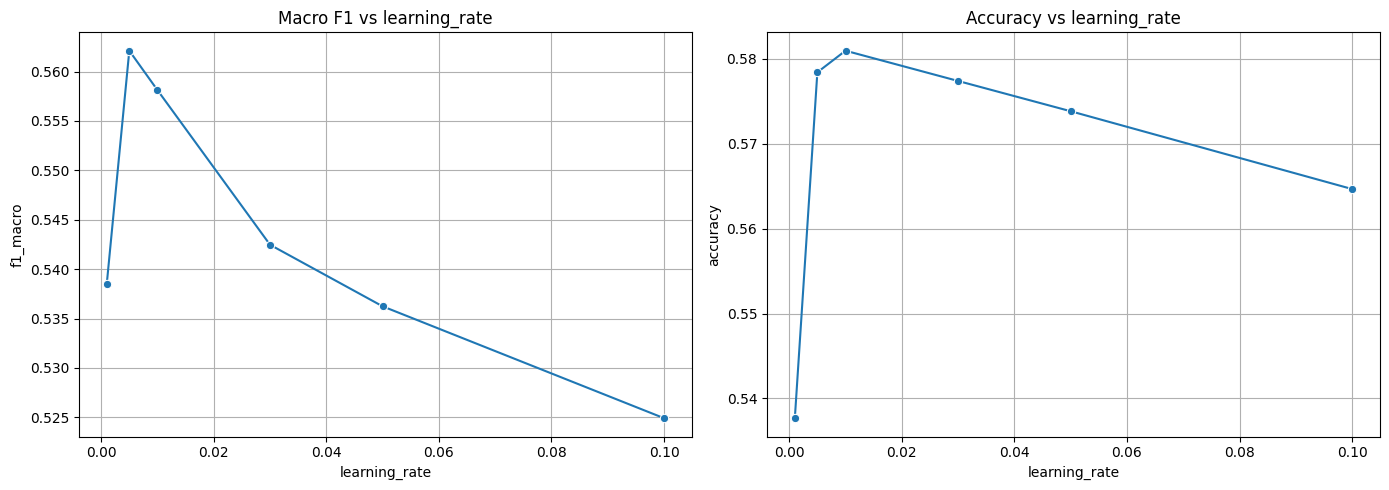

In [14]:
lr_vals = [0.005, 0.001, 0.01, 0.03, 0.05, 0.1]
df_lr = run_lgb_experiment("learning_rate", lr_vals)
plot_results(df_lr, "learning_rate")